# Feature preparation and exploratory analysis

This notebook describes feature preparation from the interpolated time series and some visual inspection of the features for the different classes of crop phenology.

## Prepare dataset for ML models

To transform the interpolated time series for useful features for classification models, we approach feature preparation as the definition of band and indices measurements on times relative to the identified class. The time difference between temporal features are defined taking in consideration an interval of 16 days. This can be changed in the dataset interpolation methods parameters.

We start by reading a previously interpolated dataset.

In [1]:
import os
import sys
import xarray as xr

nd = xr.open_dataset(os.environ['WIN_SVR_DATA']+'Saldana/features/NDVI.nc')

In [7]:
# This dataset was interpolated with intervales for 3 different dates with phenology class information
print('The dataset contains {} different dates.'.format(nd.time.values.size))

The dataset contains 36 different dates.


In [9]:
nd.close()

Now we import the prepdataset module which makes the time-series transformation and asociation with vegetation classes read from a shapefile. The *prepare_dataset* method requires the definition of:

- Shapefile location containing the polygons and phenology classes in the attribute table. In this case, we transform the different classes to numerical codes.
- Path to directory containing interpolated datasets
- Path to write the features data frame
- Tuple of associations of column names in shapefile's attribute table containing the phenology classes and the date corresponding to the classes.  

In [8]:
sys.path.append('../c_Class_Models')
from prepdataset import *

In this example, we use only the example of previously interpolated datasets for the area containing all the polygons.

In [17]:
shapefile = '/home/azalazar/data/saldana2.shp'
inloc = os.environ['WIN_SVR_DATA']+'Saldana/vars/'
outloc = os.environ['WIN_SVR_DATA']+'Saldana/features_test/'
date_class = [('X20151221', np.datetime64('2015-12-21'))]

In [15]:
# Inspect the shapefile
import geopandas as gpd
class_geodf = gpd.read_file(shapefile)
class_geodf

,IDLote,id,X20151127,X20151221,X20160107,geometry
0,21C914,1,None,5.0,NaN,POLYGON ((-74.99465349618083 3.841381841229849...
1,21C908,2,None,4.0,NaN,POLYGON ((-75.00095149839323 3.836581531193605...
2,21D813A,3,None,4.0,NaN,POLYGON ((-74.97581631362374 3.844953707948707...
3,21D823,4,1,2.0,NaN,POLYGON ((-74.98634770980443 3.851785570053677...
4,21C918,5,None,3.0,NaN,POLYGON ((-74.99660445626463 3.846711287666731...
5,21C919,6,None,3.0,4.0,POLYGON ((-75.00421888299961 3.848582255641058...
6,11B011A,7,None,4.0,NaN,POLYGON ((-75.00091361567308 3.881143997896821...
7,31D097,8,None,5.0,NaN,POLYGON ((-74.97643190782489 3.891660624885447...
8,31D091,9,None,5.0,NaN,POLYGON ((-74.97946252543086 3.893040154719708...
9,31E723,10,None,5.0,NaN,POLYGON ((-74.95834290898929 3.885188143108771...


In [18]:
prepare_dataset(inloc, outloc, date_class, shapefile)

The method writes a parquet dataset in the specified output path. We can use pandas to read as a pandas dataframe. The parquet dataset can also be loaded directly as an H2o.ai dataframe to test the machine learning models.

## Inspect dataset

In the rest of this notebook, we load a full dataset containing the three dates in the shapefile attribute table.


In [1]:
import pandas as pd

data_frame = pd.read_parquet(os.environ['WIN_SVR_DATA']+'Saldana/parquet77/')

In [2]:
print('The dataset contains {} columns, such as:'.format(data_frame.columns.values.shape[0]))
data_frame.columns.values[0:10]

The dataset contains 358 columns, such as:


array(['IDLote', 'LSWI_0', 'LSWI_16', 'LSWI_1der_0', 'LSWI_1der_16',
       'LSWI_1der_n112', 'LSWI_1der_n128', 'LSWI_1der_n144',
       'LSWI_1der_n16', 'LSWI_1der_n160'], dtype=object)

We will use some utility functions for plotting bloxplots for the separate phenology classes for one variable. A second function to to plot variable pairs in a scatterplot, showing phenology classes with a color code.

In [60]:
#Functions for plotting

from matplotlib import pyplot as plt

def show_boxplot(data_frame, variable, ax=None):
    
    data = [data_frame[variable][data_frame['vclass']==1],data_frame[variable][data_frame['vclass']==2],
            data_frame[variable][data_frame['vclass']==3],data_frame[variable][data_frame['vclass']==4],
            data_frame[variable][data_frame['vclass']==5]]
    
    if ax is None:
        mpl_fig = plt.figure()
        ax = mpl_fig.add_subplot(111)
        plt.title('Distribution of {} values per phenology class'.format(variable))

    ax.boxplot(data)
    
    ax.set_xticklabels(['Veg_Start','Veg_End','Reproductive','Ripening','Harvested'])
    
    if ax is None:
        plt.tight_layout()
        plt.show()

        
def variable_pairs(loaded, variable1, variable2):
    
    xdata = [loaded[variable1][loaded['vclass']==1], loaded[variable1][loaded['vclass']==2],
        loaded[variable1][loaded['vclass']==3], loaded[variable1][loaded['vclass']==4],
        loaded[variable1][loaded['vclass']==5]]

    ydata = [loaded[variable2][loaded['vclass']==1], loaded[variable2][loaded['vclass']==2],
             loaded[variable2][loaded['vclass']==3], loaded[variable2][loaded['vclass']==4],
             loaded[variable2][loaded['vclass']==5]]
    
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)

    plt.xlabel(variable1)
    plt.ylabel(variable2)

    ax.scatter(xdata[0], ydata[0], c='tab:blue', label='Veg_Start')
    ax.scatter(xdata[1], ydata[1], c='tab:orange', label='Veg_End')
    ax.scatter(xdata[2], ydata[2], c='tab:green', label='Reproductive')
    ax.scatter(xdata[3], ydata[3], c='tab:red', label='Ripening')
    ax.scatter(xdata[4], ydata[4], c='tab:purple', label='Harvested')

    ax.legend()


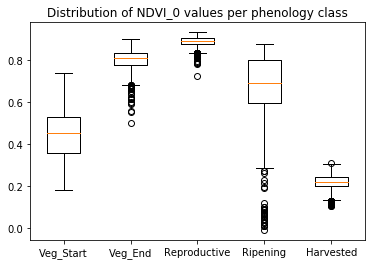

In [4]:
show_boxplot(data_frame, 'NDVI_0')

In [5]:
# We can also separate into different data frames according to any column values
date1 = data_frame[data_frame['time']=='2015-11-27']
date2 = data_frame[data_frame['time']=='2015-12-21']
date3 = data_frame[data_frame['time']=='2016-01-07']

In [63]:
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d808f1da0>,
      dtype=object)

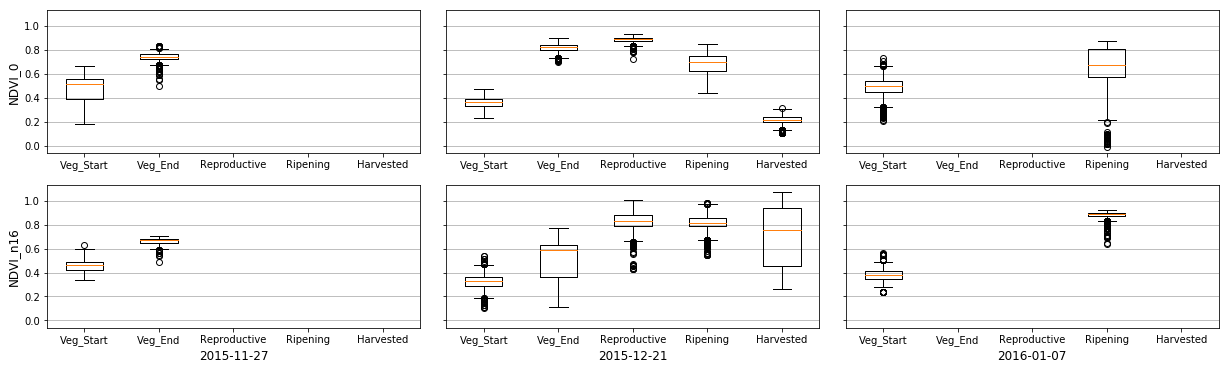

In [68]:
fig, ax = plt.subplots(2,3, figsize=(17,5), sharey=True)

plt.tight_layout()

show_boxplot(date1, 'NDVI_0', ax[0][0])
show_boxplot(date2, 'NDVI_0',ax[0][1])
show_boxplot(date3, 'NDVI_0', ax[0][2])

show_boxplot(date1, 'NDVI_n16', ax[1][0])
show_boxplot(date2, 'NDVI_n16', ax[1][1])
show_boxplot(date3, 'NDVI_n16', ax[1][2])

ax[0][0].set_ylabel("NDVI_0", fontsize=12)
ax[1][0].set_ylabel("NDVI_n16", fontsize=12)

ax[1][0].set_xlabel("2015-11-27", fontsize=12)
ax[1][1].set_xlabel("2015-12-21", fontsize=12)
ax[1][2].set_xlabel("2016-01-07", fontsize=12)

for axis in ax:
    for axs in axis:
        axs.yaxis.grid(True)

plt.show()

There seems to be more class separability in the classes from the fields in 2015-12-21. The next plots focus in this subset of pixels.

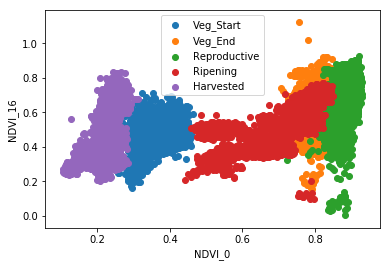

In [19]:
variable_pairs(date2, 'NDVI_0', 'NDVI_16')

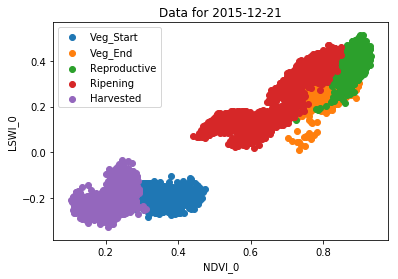

In [21]:
variable_pairs(date2, 'NDVI_0', 'LSWI_0'); plt.title('Data for 2015-12-21'); plt.show()

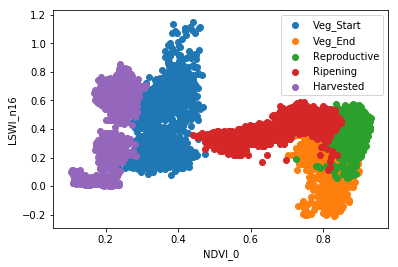

In [58]:
variable_pairs(date2, 'NDVI_0', 'LSWI_n16')

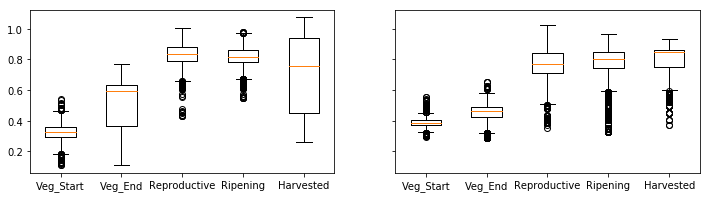

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,3),sharey=True)

show_boxplot(date2, 'NDVI_n16', ax[0])
show_boxplot(date2, 'NDVI_n32', ax[1])

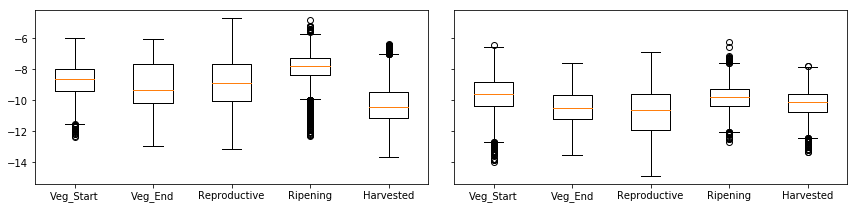

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,3), sharey=True)

plt.tight_layout()

show_boxplot(date2, 'VV_n32', ax[0])
show_boxplot(date2, 'VV_0', ax[1])

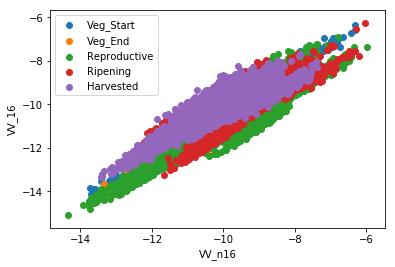

In [23]:
variable_pairs(date2, 'VV_n16', 'VV_16')

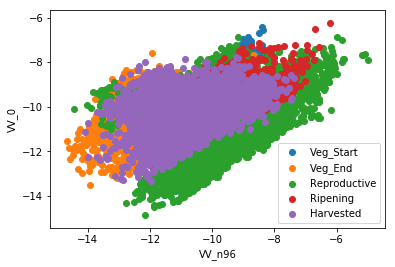

In [24]:
variable_pairs(date2, 'VV_n96', 'VV_0')

In [53]:
data_frame.vclass = data_frame.vclass.astype('category')

In [54]:
corr = data_frame.corr()

In [57]:
corr.loc['NDVI_0'].sort_values(ascending=False)

NDVI_0                       1.000000
LSWI_0                       0.878414
NDVI_n144                    0.688736
LSWI_n144                    0.676631
NDVI_1der_n48                0.617409
NDVI_n160                    0.583289
LSWI_n160                    0.565148
LSWI_16                      0.444788
NDVI_16                      0.422606
VV_GLCMVariance_n192         0.422134
NDVI_1der_n64                0.416997
VV_GLCMMean_n192             0.413947
NDVI_1der_n16                0.390234
VV_n48                       0.381854
VV_Contrast_n192             0.378295
VV_Dissimilarity_n192        0.372231
VV_n64                       0.353421
NDVI_n16                     0.324157
VV_1der_n64                  0.286575
VV_n32                       0.286492
NDVI_1der_n32                0.259405
VV_Homogeneity_1der_n32      0.258688
VV_GLCMVariance_n64          0.244294
VV_n192                      0.242529
LSWI_1der_n64                0.240731
LSWI_1der_n48                0.236892
VV_Energy_1d